# Data Story Draft
* Hugo Krijgsman (14667851)
* Ingmar Hartman (15206149)
* Julius de Groot (14362104)


## Introduction
The relationship between freedom and happiness is a crucial area of investigation, especially for informing the development of effective public policies. In Western society, there is a prevalent belief that increased freedom directly correlates with higher levels of happiness. This belief drives significant efforts to enhance personal and political freedoms. However, the reality is more complex. There are countries where people face greater limitations in their freedoms but still report high levels of happiness.

This report utilizes two key datasets to explore the relationship between freedom and happiness. The first dataset, from the Human Freedom Index, measures various aspects of freedom including personal, civil, and economic dimensions. The second dataset, from the World Happiness Report, provides happiness scores based on indicators such as GDP per capita, social support, and life expectancy.

By comparing these datasets, we aim to uncover correlations and patterns that reveal how different dimensions of freedom influence overall happiness across countries.

### Perspectives
* The more freedom citizens of a country experience, the happier they are.
* There is no correlation between freedom and happiness citizens of a country experience.

### Dependencies 


### Imports

In [86]:
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px
import pycountry 

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

## Datasets

### World Happiness Report
The World Happiness Report dataset on Kaggle contains data from the annual World Happiness Report, offering insights into the happiness levels of countries worldwide. The dataset includes information on several key indicators such as GDP per capita, social support, healthy life expectancy, freedom to make life choices, generosity, and perceptions of corruption. This comprehensive dataset allows for detailed analysis and comparison of the well-being and happiness of different nations, aiding researchers and analysts in understanding the factors that contribute to a country's overall happiness.

In [87]:
# Function for converting to iso 
def getIsoCode(country_name):
    try:
        country_iso = pycountry.countries.search_fuzzy(country_name)[0]
        return country_iso.alpha_3
    except LookupError:
        print(country_name)
        return ""

happiness_data = pd.read_csv("happiness.csv")
happiness_data["Country"] = happiness_data["Country or region"]
happiness_data = happiness_data.drop(columns=["Country or region", "Overall rank"])

happiness_data.head()

,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Country
0,7.769,1.340,1.587,0.986,0.596,0.153,0.393,Finland
1,7.600,1.383,1.573,0.996,0.592,0.252,0.410,Denmark
2,7.554,1.488,1.582,1.028,0.603,0.271,0.341,Norway
3,7.494,1.380,1.624,1.026,0.591,0.354,0.118,Iceland
4,7.488,1.396,1.522,0.999,0.557,0.322,0.298,Netherlands


### Human Freedom Index

The Human Freedom Index dataset on Kaggle includes comprehensive data on the state of human freedom globally. This dataset combines indicators of personal and economic freedom, covering a wide range of topics such as rule of law, security and safety, movement, religion, association, assembly, civil society, expression and information, identity and relationships, and economic freedoms like regulation and freedom to trade internationally. This extensive dataset facilitates in-depth analysis of the factors that influence human freedom in various countries.

In [88]:
freedom_data = pd.read_csv("freedom.csv", low_memory=False)
columns_to_drop = []

# Normalize country column
freedom_data = freedom_data.rename(columns={"countries": "Country"})
columns_to_drop.extend(["region"])

# Filter out years other than 2019
freedom_data["year"] = pd.to_numeric(freedom_data["year"], errors='coerce')
freedom_data = freedom_data[freedom_data["year"] == 2019]
columns_to_drop.append("year")

# Reset and Drop
freedom_data = freedom_data.reset_index()
columns_to_drop.append("index")
freedom_data = freedom_data.drop(columns=columns_to_drop)

freedom_data.head()

,Country,hf_score,hf_rank,hf_quartile,pf_rol_procedural,pf_rol_civil,pf_rol_criminal,pf_rol_vdem,pf_rol,pf_ss_homicide,...,ef_regulation_business_adm,ef_regulation_business_burden,ef_regulation_business_start,ef_regulation_business_impartial,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,ef_score,ef_rank
0,Albania,8.07,42.0,2.0,5.903741,4.725831,4.047825,7.375907,4.892466,9.343023,...,5.651538,6.666667,9.742477,6.2425,5.621940,7.175250,6.850062,7.700885,7.79,31.0
1,Algeria,5.08,155.0,4.0,4.913311,5.503872,4.254187,5.345021,4.890457,9.613372,...,4.215154,2.222222,9.305002,2.5775,8.771111,7.029528,5.686753,5.840164,4.86,159.0
2,Angola,5.96,127.0,4.0,2.773262,4.352009,3.478950,5.264300,3.534740,8.590305,...,2.937894,2.444444,8.730805,4.7025,7.916416,6.782923,5.585830,5.974672,5.55,153.0
3,Argentina,7.33,75.0,2.0,6.824288,5.679943,4.218635,6.570627,5.574289,8.505814,...,2.714233,5.777778,9.579288,6.5300,5.726521,6.508295,6.139352,5.994265,5.44,154.0
4,Armenia,8.32,34.0,1.0,NaN,NaN,NaN,7.287006,7.287006,9.281977,...,5.170406,5.555556,9.863530,6.9575,9.302574,7.040738,7.315051,7.819774,7.98,17.0


**Merging Both Datasets**

In [ ]:
country_name_mapping = {
    "Bahamas, The": "Bahamas",
    "Congo (Brazzaville)": "Congo",
    "Congo (Kinshasa)": "Congo",
    "Congo, Dem. Rep.": "Congo",
    "Congo, Rep.": "Congo",
    "Cote d'Ivoire": "Ivory Coast",
    "Egypt, Arab Rep.": "Egypt",
    "Gambia, The": "Gambia",
    "Hong Kong SAR, China": "Hong Kong",
    "Iran, Islamic Rep.": "Iran",
    "Korea, Rep.": "South Korea",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Lao PDR": "Laos",
    "Russia": "Russian Federation",
    "Slovak Republic": "Slovakia",
    "Swaziland": "Eswatini",
    "Syria": "Syrian Arab Republic",
    "Trinidad & Tobago": "Trinidad and Tobago",
    "Venezuela, RB": "Venezuela",
    "Yemen, Rep.": "Yemen"
}


In [89]:
happiness_data["iso"] = happiness_data['Country'].apply(getIsoCode)
freedom_data["iso"] = freedom_data['Country'].apply(getIsoCode)
    
data = pd.merge(freedom_data, happiness_data, on='iso', how='left')
data.head()

Trinidad & Tobago
Northern Cyprus
Ivory Coast
Congo (Brazzaville)
Laos
Palestinian Territories
Congo (Kinshasa)
Swaziland
Bahamas, The
Congo, Dem. Rep.
Congo, Rep.
Egypt, Arab Rep.
Gambia, The
Hong Kong SAR, China
Iran, Islamic Rep.
Korea, Rep.
Lao PDR
Venezuela, RB
Yemen, Rep.


,Country_x,hf_score,hf_rank,hf_quartile,pf_rol_procedural,pf_rol_civil,pf_rol_criminal,pf_rol_vdem,pf_rol,pf_ss_homicide,...,ef_rank,iso,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Country_y
0,Albania,8.07,42.0,2.0,5.903741,4.725831,4.047825,7.375907,4.892466,9.343023,...,31.0,ALB,4.719,0.947,0.848,0.874,0.383,0.178,0.027,Albania
1,Algeria,5.08,155.0,4.0,4.913311,5.503872,4.254187,5.345021,4.890457,9.613372,...,159.0,DZA,5.211,1.002,1.160,0.785,0.086,0.073,0.114,Algeria
2,Angola,5.96,127.0,4.0,2.773262,4.352009,3.478950,5.264300,3.534740,8.590305,...,153.0,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Argentina,7.33,75.0,2.0,6.824288,5.679943,4.218635,6.570627,5.574289,8.505814,...,154.0,ARG,6.086,1.092,1.432,0.881,0.471,0.066,0.050,Argentina
4,Armenia,8.32,34.0,1.0,NaN,NaN,NaN,7.287006,7.287006,9.281977,...,17.0,ARM,4.559,0.850,1.055,0.815,0.283,0.095,0.064,Armenia


In [90]:
fig = px.choropleth(data, locations="iso",
                    title='Freedom around the world',
                    color="hf_score", 
                    hover_name="iso", 
                    hover_data=['iso'],
                    color_continuous_scale=px.colors.sequential.Redor_r,  
                    )

fig.show()

/tmp/ipykernel_31758/2947094874.py:6: DtypeWarning: Columns (128) have mixed types. Specify dtype option on import or set low_memory=False.
  freedom_data = pd.read_csv('freedom.csv')


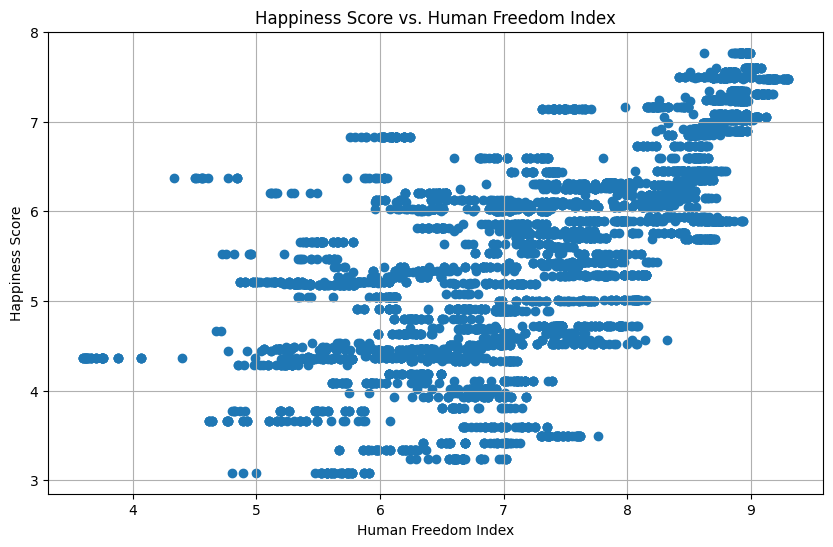

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
happiness_data = pd.read_csv('happiness.csv')
freedom_data = pd.read_csv('freedom.csv')

# Rename columns for consistency
happiness_data.rename(columns={'Country or region': 'Country'}, inplace=True)
freedom_data.rename(columns={'countries': 'Country'}, inplace=True)

# Merge datasets on 'Country'
merged_data = pd.merge(happiness_data, freedom_data, on='Country')

# Create scatter plot for Happiness Score vs. Human Freedom Index
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['hf_score'], merged_data['Score'])
plt.title('Happiness Score vs. Human Freedom Index')
plt.xlabel('Human Freedom Index')
plt.ylabel('Happiness Score')
plt.grid(True)
plt.show()
